Jianming Yang 20383255

This code uses SimpleITK to read , up-sample, transform and rewrite the brain ct data. 3D slicer is used to aid the visuliszation as well as providing a camparing information. Q1 reads the image, understand the resample basics through calculation and then perform the upscaling using spacing (0.5,0.5,0.5). Q2 uses simpleITK to perform Roration(T1) and Translation(T2) (also centering transformation) as well as investigate the effect of using different orders of T1 and T2. Q3 uses 3D Slicer to repeat the same procedures in Q1 and Q2 and helps validate and compare results.

In [7]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
%config Completer.use_jedi = False
img = sitk.ReadImage("ct_intra_lowres.nrrd")

In [8]:
def image_info(img):
    print('size: ',img.GetSize())
    print('spacing: ',img.GetSpacing())
    print('origin: ',img.GetOrigin())
    print('direction: ',img.GetDirection())
    print('pixel type: ',img.GetPixelIDTypeAsString())


In [9]:
image_info(img)

size:  (73, 73, 64)
spacing:  (3.0, 3.0, 3.0)
origin:  (104.99526214599611, 60.185997009277365, -97.80435180664065)
direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type:  32-bit signed integer


Q1.a) low resolution CT shown in 3D Slicer
<img src="Head_low.png" alt="Image Title" width="800" height="600">

Q1.b) For example, an up-sampling with a three times higher resolution: we want to decrease the pixel spacing to achieve a higher level of detail. As a result, the new spacing will be (1, 1, 1) since we are reducing the sampling window size 3 times for each direction (3/3, 3/3, 3/3).

With the reduced spacing, the new size of the up-sampled volume will be (73 * 3, 73 * 3, 64 * 3), which equals (219, 219, 192). The increased size is a direct consequence of the smaller sampling spacing, allowing for more data points within the same volume to achieve higher resolution.

However, the up-sampling process will not alter the origin, direction, and pixel type. The origin, which represents the starting pixel point, will not be affected by resample's size and spacing changes. The direction matrix, defining the orientation of the volume, will not undergo any rotation or changes in orientation either. Lastly, the pixel values, representing the intensity of the data, will also continue to be represented by a 32-bit pixel type.

In [10]:
def data_resample(img, new_spacing):
    
    # Get the current spacing of the image
    original_spacing = img.GetSpacing()
    original_size = img.GetSize()
    
    # Calculate the resampling factor which is ratio of the original spacing over the new one
    resampling_factor = [original_spacing[i] / new_spacing[i] for i in range(3)]
    
    # Use this ratio to get the new size by mutiplying with original size
    new_size = [int(original_size[i] * resampling_factor[i]) for i in range(3)]
    
    # Instantiate simpleITK's resample filter and configure it with the new size, newspacing,
    # old origin and old direction, pixel type was kept the same and use the linear interpolation
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetInterpolator(sitk.sitkLinear)
    
    # To see what changes applied to the original data
    print(resampler)
    
    # Excecute the resampling
    resampled_img = resampler.Execute(img)

    return resampled_img

In [11]:
# Q1. c) new spacing is ((0.5, 0.5, 0.5)) for resampling
new_spacing = (0.5, 0.5, 0.5)
resampled_img = data_resample(img, new_spacing)

# Export the written resampled image for 3D slicer visualiztion
sitk.WriteImage(resampled_img,"R_ct_intra.nrrd.nii")

itk::simple::ResampleImageFilter
  Size: [ 438, 438, 384 ]
  Interpolator: Linear
  OutputOrigin: [ 104.995, 60.186, -97.8044 ]
  OutputSpacing: [ 0.5, 0.5, 0.5 ]
  OutputDirection: [ 1, 0, 0, 0, 1, 0, 0, 0, 1 ]
  DefaultPixelValue: 0
  OutputPixelType: Unknown pixel id
  UseNearestNeighborExtrapolator: 0
  Debug: 0
  NumberOfThreads: 20
  NumberOfWorkUnits: 0
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess: (none)



In [12]:
# check resampled image information
image_info(resampled_img)

size:  (438, 438, 384)
spacing:  (0.5, 0.5, 0.5)
origin:  (104.99526214599611, 60.185997009277365, -97.80435180664065)
direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type:  32-bit signed integer


In [13]:
# Show calculated information in 1b to compare
print("size:  (219, 219, 192)")
print("spacing:  (1, 1, 1)")
print("origin:  (104.99526214599611, 60.185997009277365, -97.80435180664065)")
print("direction:   (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)")
print("pixel type:  32-bit signed integer")

size:  (219, 219, 192)
spacing:  (1, 1, 1)
origin:  (104.99526214599611, 60.185997009277365, -97.80435180664065)
direction:   (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type:  32-bit signed integer


Q1.c) the size is 2 times the size calculated in Q1.b) since the sapcing is halfed in c), so the eventual resolution is 2 times of the resolution in b). Also the origin, orientation and pixel types are not changed.

Q1.c) Previous exported file "R_ct_intra.nrrd.nii" directly opened in 3D Slicer
<img src="Head_high.png" alt="Image Title" width="800" height="600">

In [14]:
# Q2. a) To perform T1: a 45 degreen clockwise rotation of LP plane using resampled data

def T1(img):
    # Prepare the information from resampled data for centering process
    re_origin = img.GetOrigin()
    re_size = img.GetSize()
    re_spacing =  img.GetSpacing()

    # Use Euler3DTransform function to set up transformation1/T1
    # T1/transform1 first center the skull toward origin by providing the center coordinates as the first parameter 
    # Then the last 3 parameters are the rotation around L,P,S axis

    transform1  = sitk.Euler3DTransform([re_size[i] * re_spacing[i] / 2 + re_origin[i] for i in range(3)],0,0,-np.pi/4)
    return transform1

# Q2. a) To perform T2: A 5mm shift towards L, A 5mm shift towards A and a 10mm shift towards S

def T2():
    # Instantiate T2 using simpleITK's Euler3DTransform function
    transform2 = sitk.Euler3DTransform()
    
    # Since the data are in RAS system, configure the 5mm to wards L negative and the rest same
    transform2.SetTranslation((5, -5, 10))
    return transform2


In [15]:
# external_viewer = sitk.ImageViewer()
# slicer_app_location = r"C:\Users\59344\AppData\Local\NA-MIC\Slicer 5.2.2\Slicer.exe"
# external_viewer.SetApplication(slicer_app_location)
# external_viewer.Execute(img_transformed1)

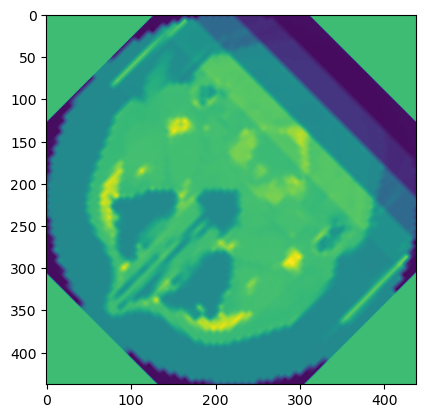

In [16]:
# Q2. b) Apply T1

# Use Resample funtion to execute transformation1 on resampled_img and use resampled_img as the grid, linear interpolation
img_transformed1 = sitk.Resample(resampled_img, resampled_img, T1(resampled_img), sitk.sitkLinear)

# Show the 45-degrees clockwise rotated slice 50 as an example
plt.imshow(sitk.GetArrayFromImage(img_transformed1[:,:,50]))

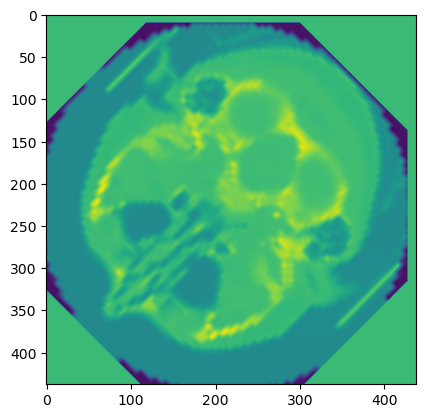

In [17]:
# Q2. b) Then apply T2

# Excecute transformation2 using resample function on the transformed image by T1, linear interpolation
img_transformed2 = sitk.Resample(img_transformed1 , img_transformed1 , T2(), sitk.sitkLinear)

# Check the changes, the volume is seen to have moved towards top and right(towards L and A)
# Pattern of the image changed also show that it was shifted towards S, go back 10 slices will 
# see similar but not the same T1 result pattern before transformation 2
plt.imshow(sitk.GetArrayFromImage(img_transformed2[:,:,50]))

In [12]:
# Examine the output of T1T2 using external viewer code to visualize the T1T2 transformed volume in 3Dslicer
external_viewer = sitk.ImageViewer()
slicer_app_location = r"C:\Users\59344\AppData\Local\NA-MIC\Slicer 5.2.2\Slicer.exe"
external_viewer.SetApplication(slicer_app_location)
external_viewer.Execute(img_transformed2)


Q2. b)
<img src="T1T2_1.png" alt="Image Title" width="800" height="600">


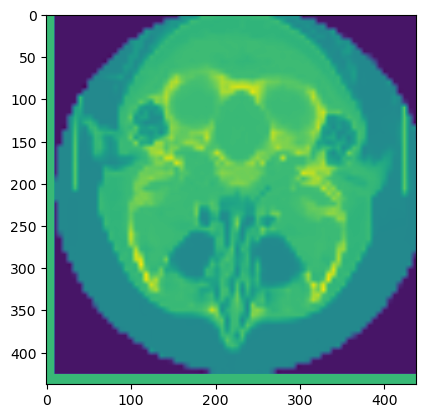

In [13]:
# Q2. c) Apply T2
img_transformed2 = sitk.Resample(resampled_img, resampled_img, T2(), sitk.sitkLinear)
plt.imshow(sitk.GetArrayFromImage(img_transformed2[:,:,50]))



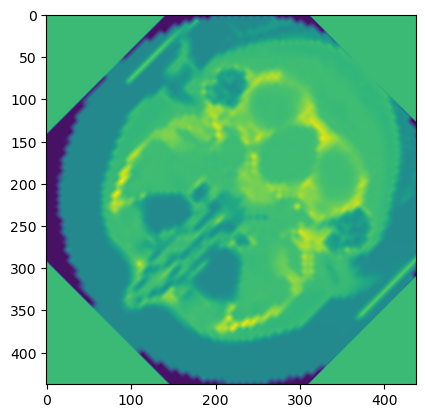

In [14]:
# Q2. c) Then pply T1
img_transformed1 = sitk.Resample(img_transformed2, img_transformed2, T1(img_transformed2), sitk.sitkLinear)
plt.imshow(sitk.GetArrayFromImage(img_transformed1[:,:,50]))

In [15]:
# Examine the output of T2T1 using external viewer code to visualize the T1T2 transformed volume in 3Dslicer
external_viewer = sitk.ImageViewer()
slicer_app_location = r"C:\Users\59344\AppData\Local\NA-MIC\Slicer 5.2.2\Slicer.exe"
external_viewer.SetApplication(slicer_app_location)
external_viewer.Execute(img_transformed1)



Q2. c) T1T2 image shifted more towards L, A and S. this is because in T1T2, centering is firsly perform then rotation and translation, so the finished position of the volume is in RAS is (-5mm,5mm,10mm) away from origin.

But in T2T1, the translation is firstly performed but centering process disgarded this change and so after the ratation the center of the vlolume stayed at the origin. So there is a difference.

<img src="T2T1_1.png" alt="Image Title" width="800" height="600">

Q3. a)
<img src="Head_3D_low.png" alt="Image Title" width="800" height="600">

Q3.b)
<img src="Head_3D_high.png" alt="Image Title" width="800" height="600">

Q3.c)
T1T2: <img src="T1T2.png" alt="Image Title" width="800" height="600">
It is more consistent with 2.b since the procedure is the same with T1 followed by T2, you can see the upper of the volume inthis image crossing the pink line as in 2b. But the Coordinates of the center of  the volume are different. Because when using simpleITK the effect of centering transformation is not shown in the 3D Slicer. The croping of the volume is also different because of the griding used in simpleITK caused loss of part of the slice image.